# Linear model try
V1.0  
This version is a first build-up of the whole system. 

### Import Libs

In [1]:
import torch
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
torch.cuda.is_available()

False

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import os
import numpy as np
import matplotlib.pyplot as plt

from model_dataset import HandshapeDataset
from paths import *
from model_model import HandshapePredictor
from model_configs import *
from utils import *
from recorder import *

### Dataset and Dataloader

In [2]:
file_prefix = "cynthia_data"
data_path = os.path.join(data_dir, file_prefix + "_data.npz")
tag_path = os.path.join(data_dir, file_prefix + "_tag.npz")

In [3]:
ds = HandshapeDataset(data_path, tag_path)

train_len = int(0.9 * len(ds))  # 80% as training data
valid_len = len(ds) - train_len  # 10% valid
# test_len = len(ds) - (train_len + valid_len)  # remaining 10% test

# Randomly split the dataset into train, validation and test sets
# train_ds, valid_ds, test_ds = random_split(ds, [train_len, valid_len, test_len])
train_ds, valid_ds = random_split(ds, [train_len, valid_len])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER)
valid_num = len(valid_loader.dataset)

# test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER)
# test_num = len(test_loader.dataset)

In [4]:
print(train_num, valid_num)

18254 2029


### Init Model

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = HandshapePredictor(
    input_dim=in_dim, 
    enc_lat_dims=enc_lat_dims, 
    hid_dim=hid_dim, 
    dec_lat_dims=dec_lat_dims, 
    output_dim=out_dim
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
model

HandshapePredictor(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=63, out_features=128, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=128, out_features=128, bias=True)
      (lin2): Linear(in_features=128, out_features=128, bias=True)
      (relu): ReLU()
    )
    (2): LinPack(
      (lin): Linear(in_features=128, out_features=32, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ResBlock(
      (lin1): Linear(in_features=32, out_features=32, bias=True)
      (lin2): Linear(in_features=32, out_features=32, bias=True)
      (relu): ReLU()
    )
    (4): LinPack(
      (lin): Linear(in_features=32, out_features=16, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, t

In [7]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

52770


In [8]:
# Just for keeping records of training hists. 
# ts = str(get_timestamp())
ts = "0816184446"
save_txt_name = "train_txt_{}.hst".format(ts)
save_trainhist_name = "train_{}.hst".format(ts)
save_valhist_name = "val_{}.hst".format(ts)
save_valacc_name = "valacc{}.hst".format(ts)

valid_losses = LossRecorder(model_save_dir + save_valhist_name)
train_losses = LossRecorder(model_save_dir + save_trainhist_name)
valid_accuracies = LossRecorder(model_save_dir + save_valacc_name)
text_hist = HistRecorder(model_save_dir + save_txt_name)

In [9]:
print("NOTE: {} is the series number this time. ".format(ts))

NOTE: 0816184446 is the series number this time. 


In [11]:
# READ = False
READ = True

In [12]:
if READ: 
    valid_losses.read()
    train_losses.read()
    valid_accuracies.read()

    # model_name = last_model_namec
    model_name = "PT_0816184446_982_full.pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)
    model.load_state_dict(state)
    model.to(device)

In [18]:
BASE = 1200
EPOCHS = 300

In [19]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, tags) in enumerate(train_loader):
            optimizer.zero_grad()

            x = x.to(device)
            x = x.to(torch.float32)
            tags = tags.to(device)
            preds = model(x)

            loss = criterion(preds, tags)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "PT_{}_{}_full.pt".format(ts, epoch)
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))
        text_hist.print("Training timepoint saved")

        model.eval()
        valid_loss = 0.
        valid_correct = 0
        valid_total = 0
        valid_num = len(valid_loader)
        for idx, (x, tags) in enumerate(valid_loader):
            x = x.to(device)
            x = x.to(torch.float32)
            tags = tags.to(device)
            preds = model(x)    # (B, C)

            loss = criterion(preds, tags)

            valid_loss += loss.item()


            predicted = torch.argmax(nn.Softmax(dim=1)(preds), dim=1)
            valid_total += tags.size(0)
            valid_correct += (predicted == tags).sum().item()

            if idx % 100 == 0:
                # \t Recon {recon / batch: .3f} \t KL {kl / batch: .3f}
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)
        valid_accuracies.append((100 * valid_correct / valid_total))
        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")
        text_hist.print(f"※※※Valid accuracy {(100 * valid_correct / valid_total): .3f} %※※※")

In [20]:
if __name__ == "__main__": 
    train()

Epoch 1200


Training loss  1.873 in Step 0
Training loss  0.983 in Step 100
Training loss  1.508 in Step 200
Training loss  1.699 in Step 300
Training loss  1.415 in Step 400
Training loss  0.965 in Step 500
※※※Training loss  1.233※※※
Training timepoint saved
Valid loss  1.766 in Step 0
※※※Valid loss  1.452※※※
※※※Valid accuracy  61.755 %※※※
Epoch 1201
Training loss  0.726 in Step 0
Training loss  0.994 in Step 100
Training loss  1.148 in Step 200
Training loss  2.037 in Step 300
Training loss  1.821 in Step 400
Training loss  1.185 in Step 500
※※※Training loss  1.253※※※
Training timepoint saved
Valid loss  1.534 in Step 0
※※※Valid loss  1.390※※※
※※※Valid accuracy  61.902 %※※※
Epoch 1202
Training loss  1.836 in Step 0
Training loss  1.471 in Step 100
Training loss  1.069 in Step 200
Training loss  1.234 in Step 300
Training loss  0.887 in Step 400
Training loss  1.104 in Step 500
※※※Training loss  1.242※※※
Training timepoint saved
Valid loss  1.793 in Step 0
※※※Valid loss  1.342※※※
※※※Valid accurac

KeyboardInterrupt: 

In [22]:
### Save
valid_losses.save()
valid_accuracies.save()
train_losses.save()
text_hist.save()

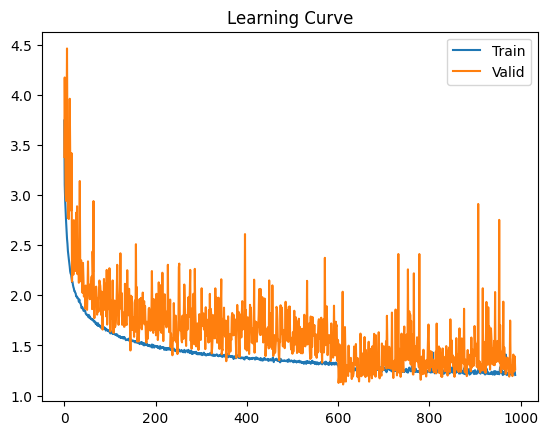

In [23]:
plt.plot(train_losses.get(), label='Train')
plt.plot(valid_losses.get(), label='Valid')
plt.title("Learning Curve")
plt.legend()

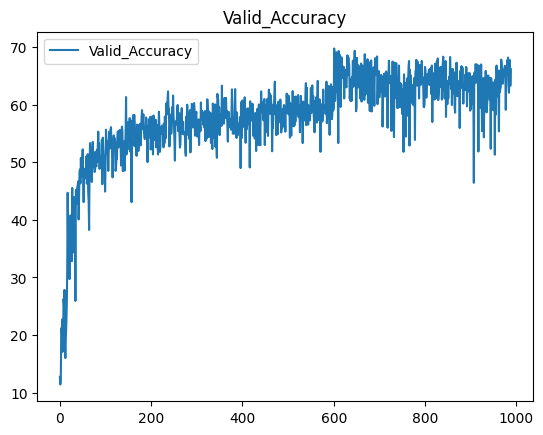

In [24]:
plt.plot(valid_accuracies.get(), label='Valid_Accuracy')
plt.title("Valid_Accuracy")
plt.legend()